In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
from halo import sim_halo
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
import utilities as ut
from utilities.constant import pc_per_cm, kpc_per_cm
from utils import Rodrigues

In [47]:
sim_name = 'm12b_res7100'
halo = sim_halo(sim_name)


# in utilities.simulation.Snapshot():
* reading:  ceph/submit/data/user/z/zimi/analysis/FIRE/m12b_res7100/snapshot_times.txt



* input redshift = 0:  using snapshot index = 600, redshift = 0.000

* read 39634 halos from:  ceph/submit/data/user/z/zimi/analysis/FIRE/m12b_res7100/halo/rockstar_dm/catalog_hdf5/halo_600.hdf5

# in halo_analysis.halo_io.Particle():
! cannot find halo file:  ceph/submit/data/user/z/zimi/analysis/FIRE/m12b_res7100/halo/rockstar_dm/catalog_hdf5/gas_600
* assigning primary host and coordinates wrt it to halo catalog...  finished


# in utilities.simulation.Snapshot():
* reading:  ceph/submit/data/user/z/zimi/analysis/FIRE/m12b_res7100/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  ceph/submit/data/user/z/zimi/analysis/FIRE/m12b_res7100/output/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 74537000 particles
    dark2     (id = 2): 6750970 particles
    gas       (id = 0): 58588459 particles
    star      (id = 4): 16869462 particles


In [48]:
halo.read_gas_files(cooling = True)
halo_gas = halo.in_halo(region = 'cgm', save = True)
r = (halo.host_radius).value

### calculate n_c and shattered cells


In [49]:
max_potential = np.max([np.max(x['potential']) for x in halo.gas_data])
max_nfw_potential = np.max([np.max(x['nfw_potential']) for x in halo.gas_data])

In [50]:
gamma = 5/3
xi = 10
k_b = const.k_B.cgs

In [51]:
%%script false --no-raise-error         # skip cell


# preparing to calculate cooling time

for i, chunk in enumerate(halo_gas):
    y = chunk['helium']
    f_e = chunk['electron_abundance']
    rho = chunk['density']
    d = chunk['smoothing_len']

    mu = 1/((1-y) + y/4 + (1-y)*f_e)
    mbar = mu*ut.constant.proton_mass
    # n = rho/mbar

    # u = halo_gas['internal_energy']
    temp = chunk['temperature']
    
    # t_cross = chunk['smoothing_len']*3.09e16/c_s                 # crossing time
    t_cool = chunk['cooling_times']                               # cooling time in cgs, positive when heating, negative when cooing
    rate_cool = np.abs(chunk['cooling_rates'])
    t_ff = (2*chunk['dist_tot']/3)*np.sqrt(-1/(chunk['nfw_potential']- max_nfw_potential) )          # freefall time in cgs, positive

    # select particles that meet shattering criteria
    shattered_idx = ((-t_cool/t_ff) < xi) & ((-t_cool/t_ff) > 0)
    shattered = chunk[shattered_idx]

    np.save(f'/ceph/submit/data/user/z/zimi/analysis/FIRE/{sim_name}/grackle_input/shattered_mask_{i}', shattered_idx)
#
    # percentage of gas shattered
    print(str(len(shattered)/len(chunk)*100) + "%" + " shattered")

    # hot phase and cold phase density
    T_c = 10**4.3   # cold temperature
    n_h = (k_b*temp)/((gamma-1)*rate_cool*xi*t_ff*(mu**2))
    n_c = (n_h*temp/T_c)[shattered_idx]

    np.save(f'/ceph/submit/data/user/z/zimi/analysis/FIRE/{sim_name}/grackle_input/n_c_{i}', n_c)

In [52]:
if isinstance(halo_gas, list):
    halo_gas = pd.concat(halo_gas)

In [53]:
# actually finding shattered cells

metal = halo_gas['metallicity']
y = halo_gas['helium']
x = 1 - metal - y
f_e = halo_gas['electron_abundance']
rho = halo_gas['density']
d = halo_gas['smoothing_len']

mu = 1/((1-y) + y/4 + (1-y)*f_e)
mbar = mu*ut.constant.proton_mass           # mean molecular mass
n = rho/mbar

# u = chunk['internal_energy']
temp = halo_gas['temperature']

# t_cross = chunk['smoothing_len']*3.09e16/c_s                 # crossing time
t_cool = halo_gas['cooling_times']                               # cooling time in cgs, positive when heating, negative when cooing
rate_cool = np.abs(halo_gas['cooling_rates'])
t_ff = (2*halo_gas['dist_tot']/3)*np.sqrt(-1/(halo_gas['nfw_potential'] - max_nfw_potential) )          # freefall time in cgs, positive

# select particles that meet shattering criteria
shattered_idx = ((-t_cool/t_ff) < xi) & ((-t_cool/t_ff) > 0)
not_shattered_idx = np.logical_not(shattered_idx)
shattered = halo_gas[shattered_idx]
not_shattered = halo_gas[not_shattered_idx]

# percentage of gas shattered
print(str(len(shattered)/len(halo_gas)*100) + "%" + " shattered")

# hot phase and cold phase density
T_c = 10**4.3   # cold temperature
n_h = (k_b*temp)/((gamma-1)*rate_cool*xi*t_ff*(mu**2))
n_c = (n_h*temp/T_c)[shattered_idx]

t_cool_cold, rate_cool_cold = halo.get_cooling(phase = 'Cold')
t_cool_cold = np.concat(t_cool_cold)

c_s = np.sqrt(gamma*k_b*T_c/mbar[shattered_idx])           # speed of sound
l = np.abs(t_cool_cold)*c_s                      # shattered cloudlet size[cm]
f_v = (n[shattered_idx]/n_h[shattered_idx] - 1)/(temp[shattered_idx]/T_c - 1)          # volume filling fraction
N_e = l*n_c*f_e[shattered_idx]*x[shattered_idx]*mu[shattered_idx]                        # electron column density [cm^-2]
n_e_new = l*n_c*f_e[shattered_idx]*x[shattered_idx]*mu[shattered_idx]                        # electron column density [cm^-2]
f_a = f_v*(d[shattered_idx]/l)                             # number of cloudlet incercepted

12.101814484770937% shattered


In [54]:
shattered['num_intercepted'] = f_a
shattered['final_size'] = l
shattered['filling_frac'] = f_v
shattered['column_dens'] = N_e
shattered['n_e_final'] = n_e_new

In [55]:
shattered_mask_2 = ((f_v >=0) & (f_v <= 1) & (l <= shattered['smoothing_len']))
not_shattered_mask_2 = np.logical_not(shattered_mask_2)

In [56]:
shattered_2 = shattered[shattered_mask_2]
not_shattered_2 = shattered[not_shattered_mask_2]

In [13]:
len(shattered_2)/len(halo_gas)

0.03377923693187442

m12f: 0.03377923362792128 of total shattered

m12z: 0.036317485995012465 of total shattered 

### some plotting

In [14]:
def plot2d(x, y, value, cmap = 'viridis', bins = 150, norm = None, vmin = None, vmax = None):
    mean, xbins, ybins, binnumber = stats.binned_statistic_2d(x, y, value, bins = bins)

    # with np.errstate(divide='ignore', invalid='ignore'):  # suppress possible divide-by-zero warnings
    plot = plt.pcolormesh(ybins, xbins, mean, cmap = cmap, norm = norm, vmin = vmin, vmax = vmax)

    return plot

(np.float64(-354.3898129265323),
 np.float64(354.39185621737806),
 np.float64(-354.4264900579318),
 np.float64(354.28727995846936))

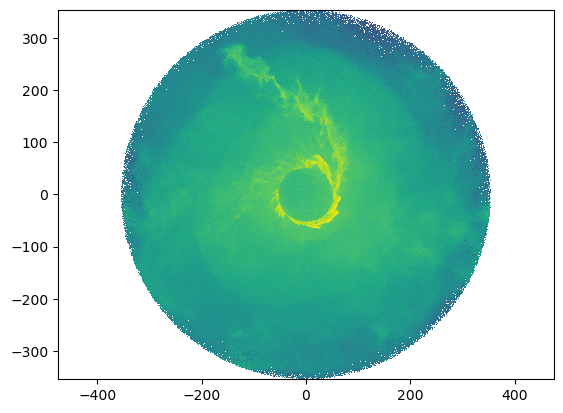

In [15]:
binsize_plot = plot2d(halo_gas['dist_x']*kpc_per_cm, halo_gas['dist_y']*kpc_per_cm, value = halo_gas['smoothing_len'], cmap = 'viridis_r', bins = [700,700])
plt.axis('equal')

In [16]:
z_center = 0
z_lim = 1/kpc_per_cm

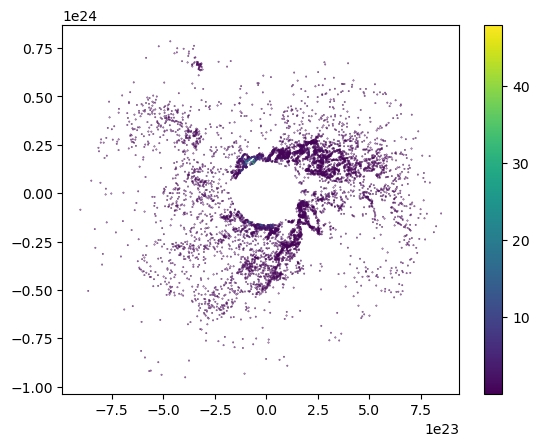

In [17]:
plt.scatter(shattered_2[np.abs(shattered_2['dist_z'] - z_center) < z_lim]['dist_x'], shattered_2[np.abs(shattered_2['dist_z'] - z_center) < z_lim]['dist_y'], 
            s = 0.1, c = shattered_2[np.abs(shattered_2['dist_z'] - z_center) < z_lim]['num_intercepted'], alpha = 1)
plt.colorbar()

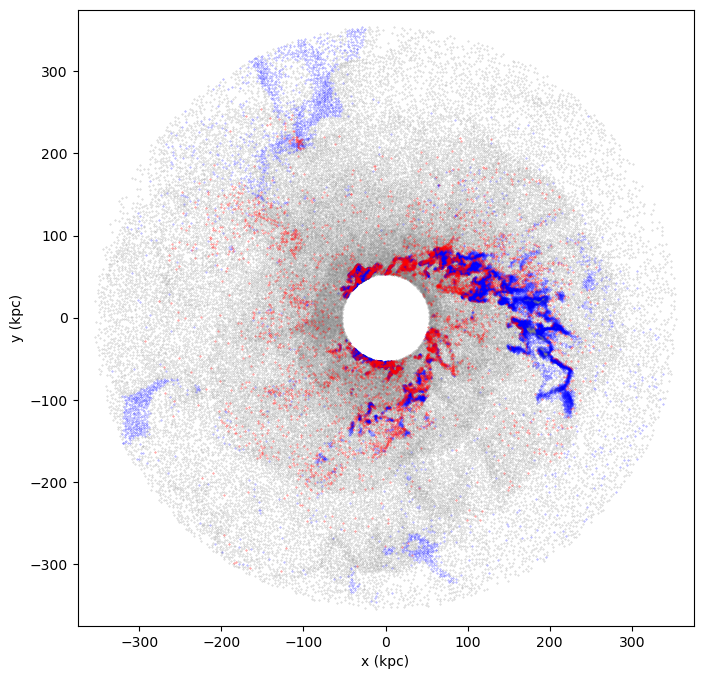

In [18]:
# shattered cells scatter plot (slice)
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(not_shattered[np.abs(not_shattered['dist_z'] - z_center) < z_lim]['dist_x']*kpc_per_cm, not_shattered[np.abs(not_shattered['dist_z'] - z_center) < z_lim]['dist_y']*kpc_per_cm, s = 0.1, c = 'grey', alpha = 0.5, label='Does not meet shattering criteria') # not shattered
ax.scatter(not_shattered_2[np.abs(not_shattered_2['dist_z'] - z_center) < z_lim]['dist_x']*kpc_per_cm, not_shattered_2[np.abs(not_shattered_2['dist_z'] - z_center) < z_lim]['dist_y']*kpc_per_cm, s = 0.1, c = 'b', alpha = 0.5, label='Begins as cool gas') # shattered with incorrect filling fraction
ax.scatter(shattered_2[np.abs(shattered_2['dist_z'] - z_center) < z_lim]['dist_x']*kpc_per_cm, shattered_2[np.abs(shattered_2['dist_z'] - z_center) < z_lim]['dist_y']*kpc_per_cm, s = 0.1, c = 'r', alpha = 0.7, label='Shattered') # shattered with correct filling fraction
# plt.legend(markerscale=10)

plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
ax.set_xlim([-375, 375])
ax.set_ylim([-375, 375])
ax.set_aspect('equal', adjustable = 'box')

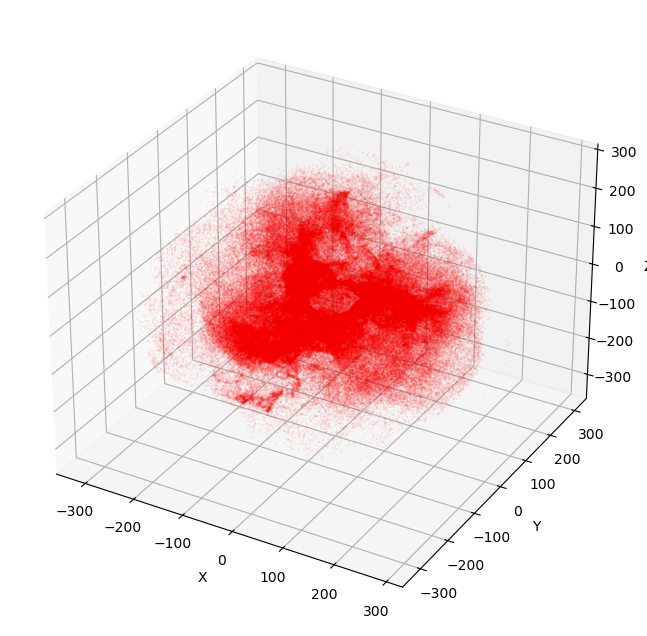

In [19]:
# 3d plot
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

#ax.scatter(not_shattered['dist_x']*kpc_per_cm, not_shattered['dist_y']*kpc_per_cm, not_shattered['dist_z']*kpc_per_cm, alpha = 0.3, c = 'grey')
#ax.scatter(not_shattered_2['dist_x']*kpc_per_cm, not_shattered_2['dist_y']*kpc_per_cm, not_shattered_2['dist_z']*kpc_per_cm, alpha = 0.1, c = 'b', s = 0.1)
ax.scatter(shattered_2['dist_x']*kpc_per_cm, shattered_2['dist_y']*kpc_per_cm, shattered_2['dist_z']*kpc_per_cm, alpha = 0.1, c = 'r', s = 0.1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

### clustering

In [20]:
X = shattered_2[['dist_x', 'dist_y', 'dist_z']]*kpc_per_cm

In [ ]:
from sklearn.cluster import HDBSCAN

clustering = HDBSCAN(min_cluster_size=10).fit(X)
labels = clustering.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

In [ ]:
from sklearn.datasets import make_blobs


def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = (labels == k).nonzero()[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

unique_labels = set(labels)
# core_samples_mask = np.zeros_like(labels, dtype=bool)
# core_samples_mask[clustering.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask] #& core_samples_mask]
    ax.scatter(
        xy['dist_x'],
        xy['dist_y'],
        xy['dist_z'],
        c=tuple(col),
        marker = "x" if k == -1 else "o",
        s=0.1,
        alpha = 0 if k == -1 else 0.5
    )

    # xy = X[class_member_mask & ~core_samples_mask]
    # plt.scatter(
    #     xy['dist_x'],
    #     xy['dist_y'],
    #     c=tuple(col),
    #     s=0.1,
    #     alpha = 0.2
    # )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

In [ ]:
def f(list):
    list[list > 1] = 1
    list[list <=1] = 0

    print(list)
    return list

fig, ax = plt.subplots(figsize=(8, 8))
# ax.scatter(not_shattered[np.abs(not_shattered['dist_z']) < z_lim]['dist_x'], not_shattered[np.abs(not_shattered['dist_z']) < z_lim]['dist_y'], s = 0.1, c = 'grey', alpha = 0.5, label='not shattered') # not shattered
# ax.scatter(not_f_v_shattered[np.abs(not_f_v_shattered['dist_z']) < z_lim]['dist_x'], not_f_v_shattered[np.abs(not_f_v_shattered['dist_z']) < z_lim]['dist_y'], s = 0.1, c = 'b', alpha = 0.5, label='incorrect f_v') # shattered with incorrect filling fraction
scatter = ax.scatter(kpc_per_cm*shattered_2[np.abs(shattered_2['dist_z']) < z_lim]['dist_x'], kpc_per_cm*shattered_2[np.abs(shattered_2['dist_z']) < z_lim]['dist_y'], 
                     s = 0.1, c = f((l[shattered_mask_2]/halo_gas['smoothing_len'][shattered_idx][shattered_mask_2])[np.abs(shattered_mask_2['dist_z']) < z_lim]),alpha = 1, label='correct f_v') # shattered with correct filling

plt.colorbar(scatter)
ax.set_aspect('equal', adjustable='datalim')
plt.title("cloudlet sizes after shattering/smoothing length")
plt.xlabel("(kpc)")
plt.ylabel("(kpc)")

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(kpc_per_cm*f_v_shattered[np.abs(f_v_shattered['dist_z']) < z_lim]['dist_x'], kpc_per_cm*f_v_shattered[np.abs(f_v_shattered['dist_z']) < z_lim]['dist_y'], s = 0.1, c = pc_per_cm*halo_gas['smoothing_len'][shattered_idx][f_v_mask][np.abs(f_v_shattered['dist_z']) < z_lim], alpha = 1) # shattered with correct filling

plt.colorbar(scatter)
ax.set_aspect('equal', adjustable='datalim')

plt.title("cloudlet sizes before shattering (pc)")
plt.xlabel("(kpc)")
plt.ylabel("(kpc)")

In [ ]:
# num shattered cells vs radius
plt.hist(shattered_2['dist_tot'], bins = 100)

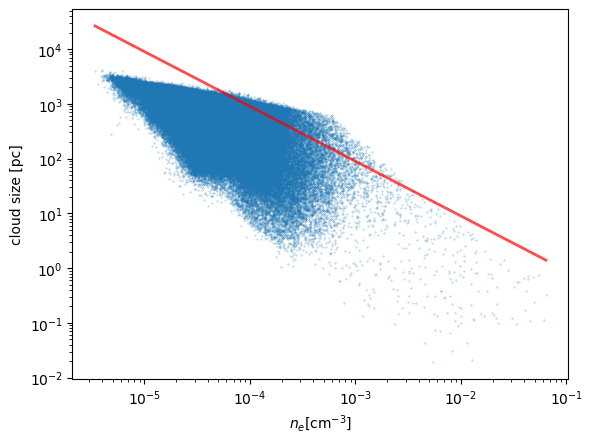

In [ ]:
#final size vs radius
plt.scatter(shattered_2['n_e'], shattered_2['final_size']*pc_per_cm, s = 0.1, alpha = 0.5,)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$n_e [\text{cm}^{-3}]$')
plt.ylabel('cloud size [pc]')

x = np.linspace(min(shattered_2['n_e']), max(shattered_2['n_e']))
y = 9*(0.01/x)
plt.plot(x, y, c = 'red', alpha = 0.7, lw = 2)
plt.savefig(f'outputs/{sim_name}/size_density', dpi = 300)

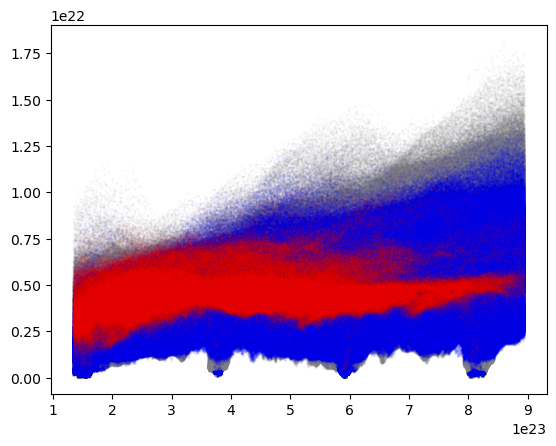

In [ ]:
fig, ax = plt.subplots()
ax.scatter(not_shattered['dist_tot'], not_shattered['smoothing_len'], s = 0.1, c = 'grey', alpha = 0.1, label='does not meet shattering criteria') # not shattered
ax.scatter(not_shattered_2['dist_tot'], not_shattered_2['smoothing_len'], s = 0.1, c = 'b', alpha = 0.1, label='begins as cool gas') # shattered with incorrect filling fraction
ax.scatter(shattered_2['dist_tot'], shattered_2['smoothing_len'], s = 0.1, c = 'r', alpha = 0.1, label='shattered') # shattered with correct filling fraction


(array([2.81887e+05, 9.15990e+04, 8.92330e+04, 9.63430e+04, 9.35490e+04,
        7.35930e+04, 6.04170e+04, 4.76870e+04, 1.94440e+04, 2.12600e+03,
        1.05000e+02, 1.30000e+01, 8.00000e+00, 7.00000e+00, 1.00000e+00,
        1.00000e+00, 3.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([3.31487366e+02, 5.33692383e+04, 1.06406984e+05, 1.59444734e+05,
        2.12482484e+05, 2.65520250e+05, 3.18558000e+05, 3.71595750e+05,
        4.24633500e+05, 4.77671250e+05, 5.30709000e+05, 5.83746750e+05,
        6.36784500e+05, 6.89822250e+05, 7.42860000e+05, 7.95897750e+05,
        8.48935500e+05, 9.01973250e+05, 9.55011000e+05, 1.00804875e+06,
        1.06108650e+06]),
 <BarContainer object of 20 artists>)

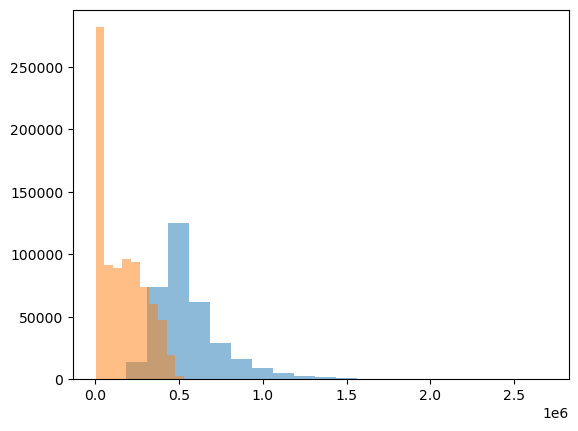

In [ ]:
plt.hist(shattered_2['temperature'], bins = 20, alpha = 0.5)
plt.hist(not_shattered_2['temperature'], bins = 20, alpha=  0.5)

### scattering

In [57]:
def find_angle_sq(input, halo_gas):
    '''
    input: dataframe for all the cells
    '''
    g_s = 2.2

    n_e = input['n_e'] # electron number density of the cold clouds???
    delta_n_e = abs(np.mean(halo_gas['n_e']) - n_e)

    # omega_p = np.sqrt((const.e.cgs)**2*n_e / const.eps0.esu / const.m_e.esu)
    omega_rest = 400 * 1e6 #megahertz

    delta_m_rest = 2 * np.pi * (const.e.esu**2) * delta_n_e / (const.m_e.cgs * (omega_rest**2))

    N_c = input['num_intercepted'] # number of clouds intersected by ray
    
    alpha_c_sq = 2*N_c*(g_s**2)*(delta_m_rest**2)

    return alpha_c_sq, delta_m_rest

In [58]:
shattered_2['alpha_sq'] = find_angle_sq(shattered_2, halo_gas)[0]
shattered_2['delta_m'] = find_angle_sq(shattered_2, halo_gas)[1]
halo.set_shattered(shattered_2)

In [59]:
# rotate galaxy 

alpha_sq = []
intercepted = []
N_img = []
col_dens = []
x= []
y= []
th = 0
rotated_gas = shattered_2.copy()

coords = shattered_2[['dist_x', 'dist_y', 'dist_z']]
rot = Rodrigues((1,0,0), th*np.pi/180)
new_coords = np.dot(coords, rot.T)
rotated_gas.loc[:, ['dist_x', 'dist_y', 'dist_z']] = new_coords

halo.set_rotated(rotated_gas)


In [ ]:
# perform ray trace

import warnings
warnings.filterwarnings('ignore')

numrays = len(np.arange(-r,r, 1))

for i in np.arange(-r,r, 1):
    for j in np.arange(-r,r, 1):
        d = halo.ray_trace_dm([i/kpc_per_cm,j/kpc_per_cm])
        
        # alpha_sq.append(alpha_c_sq)
        #N_img.append(n_img)
        # intercepted.append(num_intercepted)
        col_dens.append(d)
        
        x.append(i)
        y.append(j)

# np.save(f'outputs/{sim_name}/alpha_theta{th}', alpha_sq)
np.save(f'outputs/{sim_name}/col_dens{th}', col_dens)
# np.save(f'outputs/{sim_name}/intercepted_theta{th}', intercepted)


In [41]:
f = np.load(f'outputs/{sim_name}/col_dens0.npy')

(array([3.09051e+05, 3.49390e+04, 2.46920e+04, 1.91400e+04, 1.48540e+04,
        1.16380e+04, 1.02700e+04, 9.48500e+03, 8.60200e+03, 7.60300e+03,
        6.79300e+03, 5.92500e+03, 5.18000e+03, 4.43000e+03, 3.85800e+03,
        3.21500e+03, 2.97800e+03, 2.47400e+03, 2.22300e+03, 1.92400e+03,
        1.71700e+03, 1.62000e+03, 1.47100e+03, 1.24800e+03, 1.18300e+03,
        9.16000e+02, 8.08000e+02, 7.35000e+02, 6.64000e+02, 5.85000e+02,
        5.37000e+02, 4.86000e+02, 3.86000e+02, 3.19000e+02, 3.03000e+02,
        2.56000e+02, 2.26000e+02, 1.88000e+02, 1.51000e+02, 1.45000e+02,
        1.26000e+02, 9.90000e+01, 9.20000e+01, 7.40000e+01, 6.60000e+01,
        6.30000e+01, 4.60000e+01, 4.50000e+01, 3.50000e+01, 3.80000e+01,
        2.10000e+01, 2.70000e+01, 2.60000e+01, 1.50000e+01, 1.70000e+01,
        1.30000e+01, 6.00000e+00, 7.00000e+00, 4.00000e+00, 1.00000e+01,
        4.00000e+00, 1.00000e+00, 4.00000e+00, 5.00000e+00, 3.00000e+00,
        3.00000e+00, 5.00000e+00, 4.00000e+00, 1.00

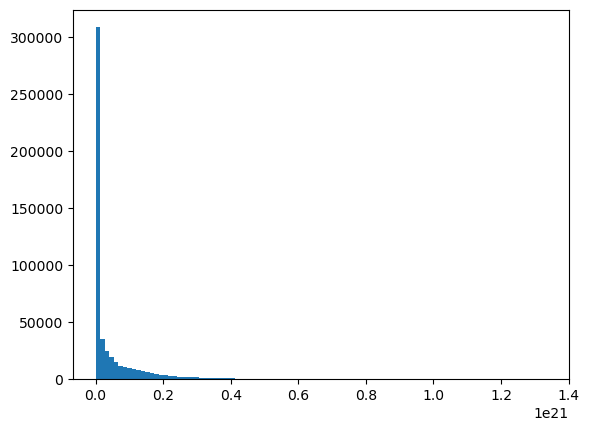

In [ ]:
# scattering timescale
z_l = 0
d_l = 3.085678e+27/2 * u.cm # 500*u.mpc
d_s = 3.085678e+27 * u.cm # 1000*u.mpc
d_ls = 3.085678e+27/2 *u.cm #500*u.mpc

tau = (1+z_l)/(2*const.c.cgs) * (d_l*d_ls/d_s) * (alpha_sq) # seconds

np.save(f'outputs/{sim_name}/time_theta{th}', tau.value)